In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import pandas as pd
import numpy as np

from mlxtend.plotting import plot_decision_regions
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer, FunctionTransformer
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from category_encoders import WOEEncoder, TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, balanced_accuracy_score, roc_auc_score

from sklearn.preprocessing import PolynomialFeatures as Poly

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz
from sklearn.tree._tree import TREE_LEAF

from sklearn.ensemble import RandomForestClassifier

from mlxtend.evaluate import feature_importance_permutation

from mlxtend.feature_extraction import PrincipalComponentAnalysis
from mlxtend.preprocessing import standardize

from mlxtend.feature_extraction import RBFKernelPCA as KPCA
from pyearth import Earth

from mlxtend.plotting import plot_pca_correlation_graph

import datetime

from sklearn.tree import _tree

from umap import UMAP

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import ClusterCentroids

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


##### Helper Functions

In [2]:
def stringify(data):
    if type(data) != pd.core.frame.DataFrame:
        X = pd.DataFrame(data)
    else:
        X = data
        
    for c in X.columns.tolist():
        X[c] = X[c].astype(str)
#     X = X.applymap(str)
    return X

In [3]:
def plot_tree(dt, used_cols, out_file='mytree.dot'):
    export_graphviz(dt, out_file=out_file, 
                    filled=True, feature_names=used_cols, 
                    leaves_parallel=True, node_ids=True, rotate=True)
    with open(out_file) as f:
        dot_graph = f.read()
    return graphviz.Source(dot_graph)
    

def prune_index(inner_tree, index, threshold):
    if inner_tree.value[index].min() < threshold:
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
    # if there are children, visit them as well
    if inner_tree.children_left[index] != TREE_LEAF:
        prune_index(inner_tree, inner_tree.children_left[index], threshold)
        prune_index(inner_tree, inner_tree.children_right[index], threshold)

In [4]:
def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    print("def tree_logic(data):")
    def recurse(node, depth):
        indent = "  " * depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if data['{}'] <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if data['{}'] > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, tree_.value[node]))
    recurse(0, 1)

##### Read data in

In [5]:
ls ../data

Terry_Stops_added_features.csv  subset.csv
Terry_Stops_raw.csv


In [6]:
df = pd.read_csv('../data/Terry_Stops_raw.csv')

In [7]:
df.head()

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,-,-1,20140000120677,92317,Arrest,None,7500,1984,M,Black or African American,...,11:32:00,-,-,-,SOUTH PCT 1ST W - ROBERT,N,N,South,O,O2
1,-,-1,20150000001670,32260,Field Contact,None,7539,1963,M,White,...,04:55:00,-,-,-,NaN,N,N,-,-,-
2,-,-1,20150000002451,46430,Field Contact,None,7591,1985,M,Hispanic or Latino,...,01:06:00,-,-,-,WEST PCT 3RD W - MARY,N,N,-,-,-
3,-,-1,20150000002815,51725,Field Contact,None,7456,1979,M,White,...,19:27:00,-,-,-,NORTH PCT 2ND W - NORA,N,N,-,-,-
4,-,-1,20150000002815,51727,Field Contact,None,7456,1979,M,White,...,19:32:00,-,-,-,NORTH PCT 2ND W - NORA,N,N,-,-,-


##### Create new target column

In [8]:
df['stop_resolution_arrest'] = 0

In [9]:
idx = df['Stop Resolution'] == 'Arrest'
df['stop_resolution_arrest'].loc[idx] = 1

In [10]:
df['stop_resolution_arrest'].value_counts()

0    29828
1     9578
Name: stop_resolution_arrest, dtype: int64

In [11]:
target = 'stop_resolution_arrest'

##### Create hour column

In [12]:
df['reported_hour'] = pd.to_datetime(df['Reported Time'], format='%H:%M:%S').dt.hour

In [13]:
df['reported_hour'].value_counts()

18    2486
2     2256
19    2219
17    2146
3     2123
1     1948
16    1882
23    1865
15    1845
14    1758
0     1723
22    1629
11    1603
13    1585
10    1518
21    1376
12    1329
5     1268
9     1243
4     1205
20    1170
8     1110
7     1089
6     1030
Name: reported_hour, dtype: int64

##### create encoded Final Call Type Column

In [14]:
# df['encoded_final_call_type'] = None
# final_call_type = list(df['Final Call Type'].unique())
# for num, call in enumerate(final_call_type):
#     df['encoded_final_call_type'].loc[df['Final Call Type'] == call] = num

In [15]:
encode_list = ['Subject Age Group', 'Officer Squad', 'Frisk Flag', 'Precinct', 'Sector', 'Beat', 
               'Final Call Type',
               'Stop Resolution', 'Weapon Type', 'Officer Gender', 'Officer Race', 'Subject Perceived Race',
               'Subject Perceived Gender']

In [16]:
for col in encode_list:
    l = list(df[col].unique())
    for num, datum in enumerate(l):
        df[col].loc[df[col] == datum] = num

In [17]:
# max value is 155, so we set null to 156 for now.
df['Officer Squad'].loc[df['Officer Squad'].isna()] = 156

##### Calculate prior probability

In [18]:
a=39397
b=9577
a/(a+b)

0.8044472577285907

##### Model

In [19]:
objectify = FunctionTransformer(func = stringify, check_inverse = False, validate=False)
binner = KBinsDiscretizer(n_bins = 10, encode = 'ordinal')
poly = Poly(degree=2)
encoder = WOEEncoder()

In [20]:
df.columns

Index(['Subject Age Group', 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
       'Stop Resolution', 'Weapon Type', 'Officer ID', 'Officer YOB',
       'Officer Gender', 'Officer Race', 'Subject Perceived Race',
       'Subject Perceived Gender', 'Reported Date', 'Reported Time',
       'Initial Call Type', 'Final Call Type', 'Call Type', 'Officer Squad',
       'Arrest Flag', 'Frisk Flag', 'Precinct', 'Sector', 'Beat',
       'stop_resolution_arrest', 'reported_hour'],
      dtype='object')

In [21]:
df.drop(df.loc[df['Officer ID'] == '-'].index, inplace = True)

In [22]:
# list of columns to exclude from the model
excluded_cols = ['Arrest Flag',
                 'stop_resolution_arrest', 'Stop Resolution',
                 'Subject ID', 'GO / SC Num', 'Terry Stop ID',
                 'Initial Call Type', 'Call Type',
                 'Reported Date', 'Reported Time',
                 'Officer YOB',
                 'Precinct', 'Sector', 'Beat',
                 'Weapon Type', 'Officer Squad', 'Subject Perceived Gender', 'reported_hour', 'Officer Gender', 'Officer Race']

used_cols = [c for c in df.columns if c not in excluded_cols]

# used_cols = ['Final Call Type']

X = df[used_cols]
y = df[target]

# ros = RandomOverSampler(random_state=0)
# X_resampled, y_resampled = ros.fit_resample(X, y)

# cc = ClusterCentroids(random_state=0)
# X_resampled, y_resampled = cc.fit_resample(X, y)


# X = X_resampled
# y = y_resampled

encoder = WOEEncoder()

# clf = LogisticRegression(class_weight='balanced',
#                         random_state = 42,
#                         n_jobs = -1)

clf = RandomForestClassifier(criterion='entropy',
                             max_depth=9,
                             n_estimators=50,
                             class_weight='balanced',
                             random_state = 42)

# scorecard = make_pipeline(objectify, encoder, poly, clf)
scorecard = make_pipeline(objectify, encoder, clf)

scores = cross_val_score(scorecard, X, y, cv=5, scoring='accuracy')
print(scores.mean(), "+/-", scores.std())

0.8004016760737287 +/- 0.01838730525097056


##### Results Tracking

1. RF, poly degree 2 :        0.8016311727421085 +/- 0.016706141027725753
2. scorecard, poly deg 2 :    0.7943480293723282 +/- 0.019881006731772424
3. scorecard, no poly :       0.7954137165320456 +/- 0.018980790283997004
4. RF, no poly :              0.8024178073281408 +/- 0.016448059074033638
5. RF, no poly, oversample :  0.6898812690746305 +/- 0.09971202464281842
6. RF, no poly, undersample : 
7. RF, no poly, less features : 0.8030672804960627 +/- 0.01765951477441695
8. scorecard, no poly, less features : 0.7983210715435037 +/- 0.01677417937204101
9. RF, no poly, 'Final Call Type' only : 0.7891096253247634 +/- 0.020291232748686716

##### Confusion Matrix

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state = 42)

In [24]:
scorecard.fit(X_train, y_train)

train_preds = scorecard.predict(X_train)
test_preds = scorecard.predict(X_test)

In [25]:
print("TRAIN:")
print(confusion_matrix(y_train, train_preds))
print('')
print("TEST:")
print(confusion_matrix(y_test, test_preds))

TRAIN:
[[19787  4094]
 [ 1068  6574]]

TEST:
[[4852 1093]
 [ 372 1564]]


#### Increase Threshold for Determining Arrest

In [41]:
threshold = 0.67 # was 0.75

train_preds_probs = (scorecard.predict_proba(X_train) > threshold).astype(int)[:,1]
test_preds_probs = (scorecard.predict_proba(X_test)  > threshold).astype(int)[:,1]

print("len(X_train)=", len(X_train))
print("len(X_test)=", len(X_test))
print("len(train_preds_probs)=", len(train_preds_probs), "sum=", sum(train_preds_probs))
print("len(y_train)=", len(y_train), "sum=", sum(y_train), "\n")
print("len(test_preds_probs)=", len(test_preds_probs),  "sum=", sum(test_preds_probs))
print("len(y_test)=", len(y_test), "sum=", sum(y_test), "\n")

print("TRAIN CONFUSION MATRIX:")
train_conf_m = confusion_matrix(y_train, train_preds_probs)
tn, fn, fp, tp = train_conf_m.ravel()
print("tn=", tn, "fn=", fn, "tp=", tp, "fp=", fp)
print(train_conf_m)
print("Accuracy=", (tp+tn)/(tp+fp+tn+fn))

print('')

print("TEST CONFUSION MATRIX:")
test_conf_m = confusion_matrix(y_test, test_preds_probs)
tn, fn, fp, tp = test_conf_m.ravel()
print("tn=", tn, "fn=", fn, "tp=", tp, "fp=", fp)
print(test_conf_m, "\n")
print("Accuracy=", (tp+tn)/(tp+fp+tn+fn))

len(X_train)= 31523
len(X_test)= 7881
len(train_preds_probs)= 31523 sum= 8480
len(y_train)= 31523 sum= 7662 

len(test_preds_probs)= 7881 sum= 2007
len(y_test)= 7881 sum= 1916 

TRAIN CONFUSION MATRIX:
tn= 21239 fn= 2622 tp= 5858 fp= 1804
[[21239  2622]
 [ 1804  5858]]
Accuracy= 0.8595945817339721

TEST CONFUSION MATRIX:
tn= 5280 fn= 685 tp= 1322 fp= 594
[[5280  685]
 [ 594 1322]] 

Accuracy= 0.8377109503870067


##### Feature Importance Permutation

In [27]:
for i, col in enumerate(used_cols):
    print(i, ":", col)

0 : Subject Age Group
1 : Officer ID
2 : Subject Perceived Race
3 : Final Call Type
4 : Frisk Flag


In [28]:
from mlxtend.evaluate import feature_importance_permutation
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, 
                                                    test_size=.20, random_state=42, 
                                                    stratify=y.values)
encoder = WOEEncoder()
scorecard = make_pipeline(objectify, encoder, clf)
scorecard.fit(X_train, y_train)
imp_vals, _ = feature_importance_permutation(
    predict_method=scorecard.predict, 
    X=X_test,
    y=y_test,
    metric='accuracy',
    num_rounds=1,
    seed=1)

print(imp_vals)

[0.00685192 0.01763736 0.00139576 0.20987184 0.00558305]


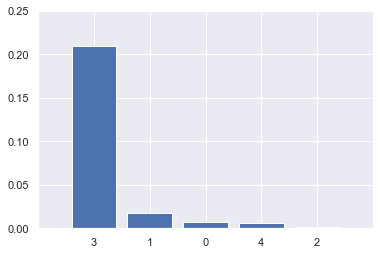

In [29]:
indices = np.argsort(imp_vals)[::-1]
plt.figure()
plt.bar(range(X.shape[1]), imp_vals[indices])
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylim([0, 0.25])
plt.show()

#### UMAP with Long Tail

In [30]:
reducer = UMAP(metric='hamming')
embedding = reducer.fit_transform(df[used_cols], y=df[target])
embedding.shape

(39404, 2)

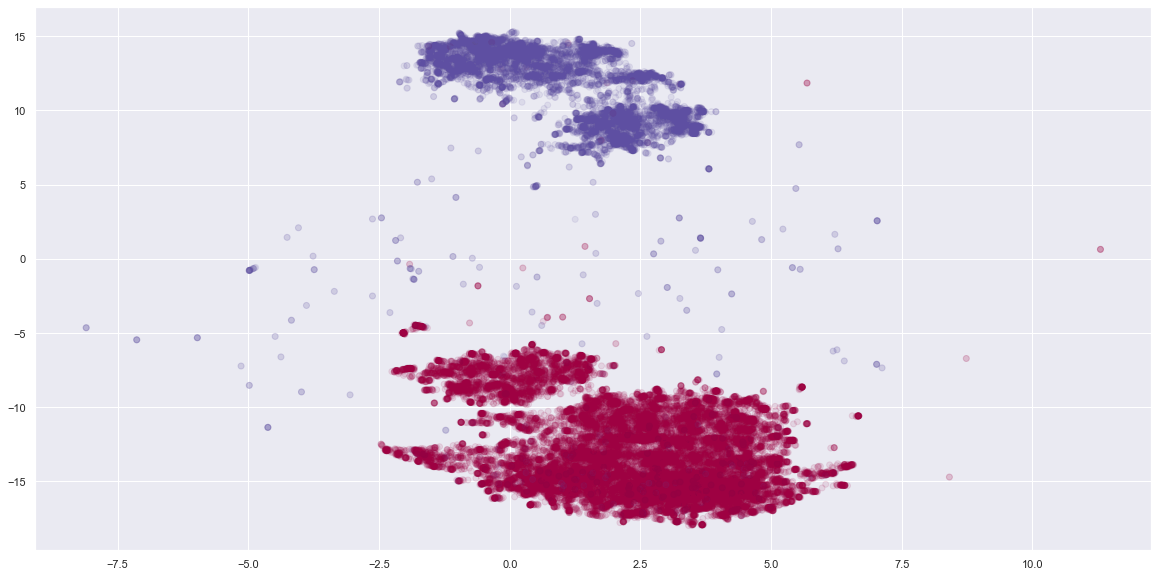

In [31]:
sample_emb = embedding
plt.figure(figsize=(20,10))
plt.scatter(sample_emb[:, 0], sample_emb[:, 1], c=df[target].values, cmap='Spectral', alpha=0.1)

#### Reducing the Lomg Tail by Binning

* 0 : Subject Age Group
* 1 : Officer ID
* 2 : Subject Perceived Race
* 3 : Final Call Type
* 4 : Frisk Flag => okay

In [32]:
# sum_c = 0
# search_n = 6
# col='Officer ID'
# for c, i in zip(df[col].value_counts(),df[col].value_counts().index) :
#     if c == search_n:
#        sum_c += c
# #       print(i, c)
# print(sum_c)

In [33]:
def compress_column(col, search_n):
    sum_c = 0
    my_max = df[col].max()

    for c, i in zip(df[col].value_counts(),df[col].value_counts().index) :
        if c <= search_n:
           df[col].loc[df[col]== i] = my_max+1

In [34]:
col = 'Final Call Type'
for search_n in [4, 9, 14, 18, 22, 27]:
    compress_column(col, search_n)

In [35]:
col = 'Subject Perceived Race'
df[col] = df[col].astype(int)
for search_n in [809]:
    compress_column(col, search_n)

In [36]:
col = 'Officer ID'
df[col] = df[col].astype(int)
for search_n in [1, 2, 3, 4, 5]:
    compress_column(col, search_n)

#### UMAP Again After Reducing Long Tail

In [37]:
reducer = UMAP(metric='hamming')
embedding = reducer.fit_transform(df[used_cols], y=df[target])
embedding.shape

(39404, 2)

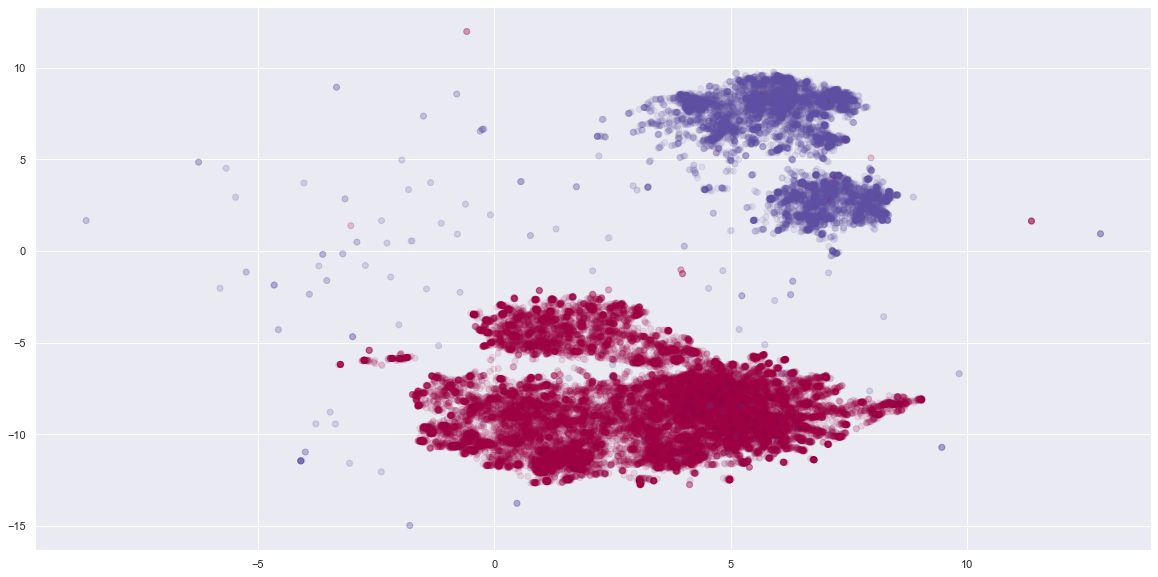

In [38]:
sample_emb = embedding
plt.figure(figsize=(20,10))
plt.scatter(sample_emb[:, 0], sample_emb[:, 1], c=df[target].values, cmap='Spectral', alpha=0.1)

In [39]:
X, y = df[used_cols], df[target]

reducer = UMAP(metric='hamming')
clf = RandomForestClassifier(class_weight='balanced')
pipe = make_pipeline(reducer, clf)

scores = cross_val_score(pipe, X, y, cv=5, scoring='accuracy')
print(scores.mean(), "+/-", scores.std())

0.8067714228849567 +/- 0.016020958215947935


In [40]:
#0.8079641939072124 +/- 0.01696768814865881